In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Add "eagerEval.enabled" to beautify the way Spark DF is displayed

In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

**Note:** column "distCol" is added to show the distance between each row and the key

## Applying LSH to real volume of data

In [5]:
news_spark = spark.read.parquet('gs://msca-bdp-data-open/news_similar/')
news_spark.count()

100343

In [6]:
df_text_raw = news_spark.select(["title"]).withColumnRenamed('title', 'text')


In [7]:
df_text_raw.limit(5)

text
Local police on a...
Biden Revokes Tr...
Woolworths superm...
"Boy, 12, dies two..."
TikTok Planning t...


In [9]:
df_text_raw.printSchema()

root
 |-- text: string (nullable = true)



### Step 1.  Clean the data, remove stopwords and create index

In [11]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

# tokens = text\
#     .map( lambda document: document.strip().lower())\
#     .map( lambda document: re.split(" ", document))\
#     .map( lambda word: [x for x in word if len(x) > 1] )\
#     .zipWithIndex()

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .zipWithIndex()

In [12]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

Exception in thread "serve RDD 23" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


text,id
{Local police on ...,0
{ Biden Revokes T...,1
{Woolworths super...,2
"{Boy, 12, dies tw...",3
{TikTok Planning ...,4


In [13]:
df_text.count()

100343

In [14]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[local, police, alert, wake, alleged, school, violence, campaign, reading]",0
1,"[biden, revokes, chinese, apps, orders, indian, defence, news]",1
2,"[woolworths, supermarket, worker, bizarre, discovery, viral, tiktok, video, 7news]",2
3,"[dies, weeks, attempting, dangerous, tiktok]",3
4,"[move, business]",4


In [15]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [16]:
df_tokens.count()

98760

### Step 2. Fit countvectorizer to create word features

In [17]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [18]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[local, police, alert, wake, alleged, school, violence, campaign, reading]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[biden, revokes, chinese, apps, orders, indian, defence, news]",1,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[woolworths, supermarket, worker, bizarre, discovery, viral, tiktok, video, 7news]",2,"(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[dies, weeks, attempting, dangerous, tiktok]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[move, business]",4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Step 3. Fit MinHashLSH to create hash table

**Note:** Adding more hash tables will increase the accuracy at the expense of training time

In [19]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [20]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
19,{NJ Twins Ask Ste...,"[twins, adopt, vi...","(27625,[0,1,4,9,1...","[[4.7945584E7], [..."
54,{TikTok testing '...,"[tiktok, testing,...","(27625,[0,16,132,...","[[4.7945584E7], [..."
296,{Facebook and Tik...,"[facebook, tiktok...","(27625,[0,21,42,1...","[[4.7945584E7], [..."
926,{Biden team asks ...,"[biden, team, ask...","(27625,[0,67,155,...","[[4.7945584E7], [..."
965,{Videos con el ha...,"[videos, hashtag,...","(27625,[0,2,6],[1...","[[4.7945584E7], [..."


### Step 4. Establish similarity threshold and return near-duplicate records
**Note:** we are joining dataframe to itself to get near-duplicate pairs

#### Low jaccard distance

In [21]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [22]:
df_dups_30 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

22/11/17 23:30:14 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 11 for reason Container marked as failed: container_1668672144784_0019_01_000012 on host: hub-msca-bdp-dphub-students-zhiliny-sw-z1x2.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/11/17 23:30:14 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 12 for reason Container marked as failed: container_1668672144784_0019_01_000013 on host: hub-msca-bdp-dphub-students-zhiliny-sw-z1x2.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/11/17 23:30:14 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 12 on hub-msca-bdp-dphub-students-zhiliny-sw-z1x2.c.msca-bdp-students.internal: Container marked as failed: container_1668672144784_0019_01_000013 on host: hub-msca-bdp

,distCol,id_A,id_B,text_A,text_B
0,0.0,418,71579,"(#สาวบีทาเก้น Hashtag Videos on TikTok,)","(#自己的歌自己做 Hashtag Videos on TikTok,)"
1,0.0,418,12303,"(#สาวบีทาเก้น Hashtag Videos on TikTok,)","(#votetiktop Hashtag Videos on TikTok,)"
2,0.0,418,69136,"(#สาวบีทาเก้น Hashtag Videos on TikTok,)","(#happysweat Hashtag Videos on TikTok,)"
3,0.0,418,444,"(#สาวบีทาเก้น Hashtag Videos on TikTok,)","(#joseywales Hashtag Videos on TikTok,)"
4,0.0,418,6163,"(#สาวบีทาเก้น Hashtag Videos on TikTok,)","(#rangamma Hashtag Videos on TikTok,)"


In [23]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

22/11/17 23:37:25 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 12.0 in stage 60.0 (TID 1174) (hub-msca-bdp-dphub-students-zhiliny-sw-zqlv.c.msca-bdp-students.internal executor 5): FetchFailed(BlockManagerId(21, hub-msca-bdp-dphub-students-zhiliny-sw-9x8c.c.msca-bdp-students.internal, 7337, None), shuffleId=10, mapIndex=126, mapId=909, reduceId=12, message=
org.apache.spark.shuffle.FetchFailedException: Failed to connect to hub-msca-bdp-dphub-students-zhiliny-sw-9x8c.c.msca-bdp-students.internal/10.128.0.2:7337
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:775)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:690)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:70)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	a

Total records:  100343
Duplicate titles based on { 0.3 } jaccard distance:  41627
Unique titles based on { 0.3 } jaccard distance:  0.3 :  58716


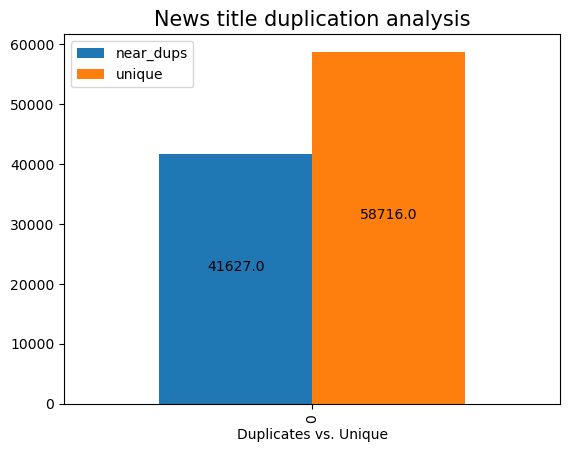

In [24]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Medium jaccard distance

In [26]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [ ]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.25,2568,21835,"(Netflix, TikTok block services in Russia to avoid crackdown - AP - Setopati,)","(Netflix, TikTok block services in Russia to avoid crackdown - WTMJ,)"
1,0.00,5628,23673,"(#knowdown Hashtag Videos on TikTok,)","(#poltagon Hashtag Videos on TikTok,)"
2,0.00,5628,13886,"(#knowdown Hashtag Videos on TikTok,)","(#ronniecolemanpolice Hashtag Videos on TikTok,)"
3,0.00,5628,33284,"(#knowdown Hashtag Videos on TikTok,)","(#可处关系不处闺蜜✨ Hashtag Videos on TikTok,)"
4,0.00,5628,19074,"(#knowdown Hashtag Videos on TikTok,)","(#uditnarayanan Hashtag Videos on TikTok,)"


In [28]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  100343
Duplicate titles based on { 0.5 } jaccard distance:  49379
Unique titles based on { 0.5 } jaccard distance:  0.5 :  50964


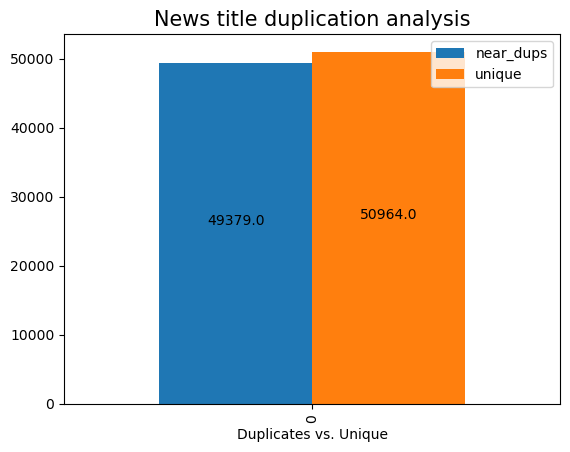

In [29]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### High jaccard distance

In [33]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [34]:
df_dups_70 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

22/11/18 00:35:20 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 47 for reason Container marked as failed: container_1668672144784_0019_01_000051 on host: hub-msca-bdp-dphub-students-zhiliny-sw-x9l6.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/11/18 00:35:20 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 48 for reason Container marked as failed: container_1668672144784_0019_01_000052 on host: hub-msca-bdp-dphub-students-zhiliny-sw-x9l6.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/11/18 00:35:20 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 48 on hub-msca-bdp-dphub-students-zhiliny-sw-x9l6.c.msca-bdp-students.internal: Container marked as failed: container_1668672144784_0019_01_000052 on host: hub-msca-bdp

,distCol,id_A,id_B,text_A,text_B
0,0.000000,1480,33312,"(#waistlinewednesdays Hashtag Videos on TikTok,)","(#thelablove_feature Hashtag Videos on TikTok,)"
1,0.000000,1480,40998,"(#waistlinewednesdays Hashtag Videos on TikTok,)","(#hurstville Hashtag Videos on TikTok,)"
2,0.000000,1480,51016,"(#waistlinewednesdays Hashtag Videos on TikTok,)","(#_prfect Hashtag Videos on TikTok,)"
3,0.000000,1480,39953,"(#waistlinewednesdays Hashtag Videos on TikTok,)","(#leiaparaseubebe Hashtag Videos on TikTok,)"
4,0.666667,1480,95142,"(#waistlinewednesdays Hashtag Videos on TikTok,)","(#dahoodtips TikTok पर हैशटैग वीडियो,)"


In [35]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  100343
Duplicate titles based on { 0.7 } jaccard distance:  76971
Unique titles based on { 0.7 } jaccard distance:  0.7 :  23372


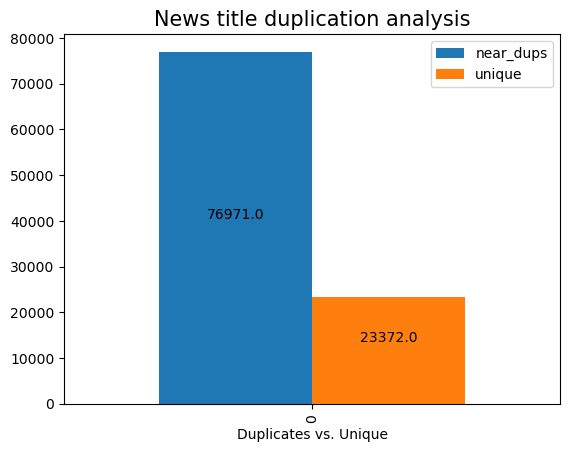

In [36]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Step 5. Compare thresholds side-by-side

#### Select all pairs of duplicate titles across jaccard similarities

In [37]:
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

22/11/18 00:41:52 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 149.0 in stage 140.0 (TID 3618) (hub-msca-bdp-dphub-students-zhiliny-sw-2p0v.c.msca-bdp-students.internal executor 59): FetchFailed(BlockManagerId(18, hub-msca-bdp-dphub-students-zhiliny-sw-45jd.c.msca-bdp-students.internal, 7337, None), shuffleId=10, mapIndex=76, mapId=882, reduceId=149, message=
org.apache.spark.shuffle.FetchFailedException: Connecting to hub-msca-bdp-dphub-students-zhiliny-sw-45jd.c.msca-bdp-students.internal:7337 failed in the last 4750 ms, fail this connection directly
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:775)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:690)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:70)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Itera

14440844


22/11/18 00:48:21 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 91.0 in stage 149.0 (TID 4006) (hub-msca-bdp-dphub-students-zhiliny-sw-7xs5.c.msca-bdp-students.internal executor 53): FetchFailed(BlockManagerId(39, hub-msca-bdp-dphub-students-zhiliny-sw-rk9r.c.msca-bdp-students.internal, 7337, None), shuffleId=14, mapIndex=19, mapId=1644, reduceId=91, message=
org.apache.spark.shuffle.FetchFailedException: Failed to connect to hub-msca-bdp-dphub-students-zhiliny-sw-rk9r.c.msca-bdp-students.internal:7337
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:775)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:690)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:70)
	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.c

14645154
24772685


In [38]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

dups_combined.limit(5)

text_A,text_B,id_70_A,id_70_B,id_50_A,id_50_B,id_30_A,id_30_B
{TikTok may let c...,{#ㄎㄧㄤ系列 Hashtag V...,26,76971,null,null,null,null
{TikTok may let c...,{#desi_sc Hashtag...,26,92249,null,null,null,null
{US drops Trump o...,{US drops Trump o...,270,20185,270,20185,270,20185
{#สาวบีทาเก้น Has...,{#bodyluv Hashtag...,418,98903,418,98903,418,98903
{#lennischallenge...,{#haneunjung Hash...,446,54005,446,54005,446,54005


#### Create a Duplicate vs Non-Dup flag for each jaccard similarity

In [39]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

dups_combined.limit(5)

text_A,text_B,threshold_30,threshold_50,threshold_70
{Woolworths super...,{ALDI supermarket...,Non-Dup,Non-Dup,Duplicate
{Woolworths super...,{Woolworths super...,Non-Dup,Non-Dup,Duplicate
"{Boy, 12, dies tw...",{Parents sue TikT...,Non-Dup,Non-Dup,Duplicate
"{Boy, 12, dies tw...","{Okla. boy, 12, d...",Non-Dup,Non-Dup,Duplicate
"{Boy, 12, dies tw...","{Tijuana boy, 9, ...",Non-Dup,Non-Dup,Duplicate


#### Select a sample of records across 3 thresholds (jaccard similarities):
* Records that are marked as duplicate by all three thresholds (meet the level of **threshold_30**)
* Records that are identified as non-duplicate by **threshold_30**, while being marked as dups by both **threshold_50** and **threshold_70**
* Records that are identified as non-duplicate by both **threshold_30** and **threshold_50**, while being marked as dups by **threshold_70**

In [40]:
dups_combined_sample = \
dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_30', 'threshold_50', 'threshold_70')

In [41]:
pd.set_option('display.max_rows', 30)
dups_combined_sample.toPandas()

,text_A,text_B,threshold_30,threshold_50,threshold_70
0,"(Coldplay to perform livestreamed set exclusively on TikTok,)","(Coldplay to perform livestreamed set exclusively on TikTok,)",Duplicate,Duplicate,Duplicate
1,"(Trump's attempt to ban TikTok in US dropped by Biden White House | 10tv.com,)","(Trump's attempt to ban TikTok in US dropped by Biden White House | wzzm13.com,)",Duplicate,Duplicate,Duplicate
2,"(Dutch group launches data harvesting claim against TikTok ,)","(Dutch group launches data harvesting claim against TikTok,)",Duplicate,Duplicate,Duplicate
3,"(Founder of TikTok's Chinese owner stepping down as CEO,)","(Founder of TikTok's Chinese owner stepping down as CEO,)",Duplicate,Duplicate,Duplicate
4,"(YouTube, Facebook, TikTok block Russian state media across Europe,)","(Meta, YouTube, and TikTok block Russian state media in Europe : worldnews,)",Duplicate,Duplicate,Duplicate
5,"(TikTok star’s son killed in Alabama shooting, family confirms | KTSM 9 News,)","(TikTok star’s son killed in Alabama shooting, family confirms | KETK.com | FOX51.com,)",Duplicate,Duplicate,Duplicate
6,"(Charge: Teen hit disabled teacher; apparent TikTok challenge,)","(Charge: Teen hit disabled teacher; apparent TikTok challenge - NewsBreak,)",Duplicate,Duplicate,Duplicate
7,"(US drops Trump order targeting TikTok, plans its own review,)","(US drops Trump order targeting TikTok, plans its own review | WTOP,)",Duplicate,Duplicate,Duplicate
8,"(North Carolina tattoo artist amasses large TikTok following,)","(North Carolina tattoo artist amasses large TikTok following | Biloxi Sun Herald,)",Duplicate,Duplicate,Duplicate
9,"(Florida Dollar General store manager says she was fired over viral TikToks | mypanhandle.com,)","(Florida Dollar General store manager says she was fired over viral TikToks | OurQuadCities,)",Duplicate,Duplicate,Duplicate


22/11/18 00:52:54 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_225_29 !
22/11/18 00:52:54 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_225_187 !
22/11/18 00:52:54 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_225_144 !
22/11/18 00:52:54 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_121_175 !
22/11/18 00:52:54 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_225_9 !
22/11/18 00:52:54 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_162_93 !
22/11/18 00:52:54 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_225_189 !
22/11/18 00:52:54 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_225_143 !
22/11/18 00:52:54 WARN org.apache.sp

#### From the sample datafrmme above, we can see that jaccard distance = 0.5 is best here. 
#### Because when jaccard distance = 0.3, the model has large number of True negative error
#### When jaccard distance = 0.7, the model has large number of False Positive error

### Build a histogram showing the overall distribution of “near-duplication”

In [ ]:
import matplotlib.pyplot as plt
duptitle70= 76971
duptitle50= 49379
duptitle30= 41627

xaxis = [0.3,0.5,0.7]
plt.plot(xaxis,[duptitle30,duptitle50,duptitle70])
plt.title('Overall New-Duplication Distribution')
plt.xlabel('jaccard distance')
plt.ylabel('New-Deplication Counts')
plt.show()

'Tue, 26 January 2021 11:09:16'